In [1]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
vgg16 = VGG16(weights='imagenet', include_top=False)
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [3]:
img_path = 'C:/Users/ustundag/Desktop/test_rgb.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
print(type(x))
x = np.expand_dims(x, axis=0)
print(type(x))
x = preprocess_input(x)
print(type(x))

#LAYER_NAME = 'block5_pool'
#model = Model(vgg16.input, vgg16.get_layer(LAYER_NAME).output)
features = vgg16.predict(x)
print(features.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1, 7, 7, 512)


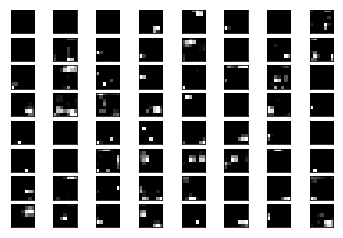

In [4]:
# plot the output from each block
square = 8
for fmap in features:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[:, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

In [11]:
import assets.utils as u
VALID_OBJECTS = ('board','bookcase','chair','door','sofa','table','window')

import glob
from PIL import Image
from scipy.io import savemat, loadmat
from IPython.display import display, clear_output

def get_label(pix):
    labels = u.load_labels('C:/Users/ustundag/Github/2D-3D-Semantics/assets/semantic_labels.json')
    limit = len(labels)
    i = u.get_index(pix)
    if i < limit:
        instance_label = labels[i]
        instance_label_as_dict = u.parse_label(instance_label)
        label = instance_label_as_dict["instance_class"]
        return label
    return '<UNK>' # unknown in case index is out of bounds in "labels.json" file

def read_image(path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def save_features_and_labels(file):
    paths = glob.glob("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\area_3\\data\\rgb\\*.png")
    features = []
    labels = []
    i = 1
    for path in paths:
        clear_output(wait=True)
        img  = read_image(path)
        fmap = vgg16.predict(img)
        # fmap = (1, 7, 7, 512)
        fmap = fmap.reshape(fmap.shape[0], fmap.shape[1]*fmap.shape[2], fmap.shape[3])

        # Replace 2 occurrences to find counterpart of RGB image as Semantic
        sem_file   = path.replace("rgb", "semantic", 2)
        sem_img    = np.asarray(Image.open(sem_file).resize((7,7)))
        sem_pixels = sem_img.reshape(sem_img.shape[0]*sem_img.shape[1], sem_img.shape[2])
        #unique_pixels = np.unique(sem_pixels, axis=0)
        valid_indexes = [[np.argwhere((sem_pixels == p).all(axis=1))[0,0], get_label(p)]
                            for p in sem_pixels
                            if get_label(p) in VALID_OBJECTS]
        # first value = feature index, second value = label
        for idx in valid_indexes:
            features.append(fmap[0,idx[0],:])
            labels.append(VALID_OBJECTS.index(idx[1]))

        display(str(i) + " / 3704")
        i += 1
    
    savemat(file,{'features': np.asarray(features),
                  'labels'  : np.asarray(labels)})

In [12]:
file = 'area_3_data_rgb_normal_VGG16_dims_224_224_7_7_weights_added.mat'
save_features_and_labels(file)

'3704 / 3704'

In [13]:
data = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\"+file)
features = data["features"]
labels   = data["labels"]

In [14]:
features.shape

(50167, 512)

In [15]:
labels.shape

(1, 50167)